# Setup


In [ ]:
# !wget https://developer.nvidia.com/compute/cuda/10.0/Prod/local_installers/cuda-repo-ubuntu1604-10-0-local-10.0.130-410.48_1.0-1_amd64 -O cuda-repo-ubuntu1604-10-0-local-10.0.130-410.48_1.0-1_amd64.deb
# !dpkg -i cuda-repo-ubuntu1604-10-0-local-10.0.130-410.48_1.0-1_amd64.deb
# !apt-key add /var/cuda-repo-10-0-local-10.0.130-410.48/7fa2af80.pub
# !apt-get update
# !apt-get install cuda
# !pip install tensorflow-gpu

In [ ]:
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from google.colab import drive 

!nvcc -V
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
# print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

gdir = '/gdrive/MyDrive/Thumbnail-Evaluator'

data_dir = '/image_data/'
test_data_dir = '/image_test_data/'
!ls /image_data

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
ls: cannot access '/image_data': No such file or directory


# Preprocess Data

In [ ]:
!git clone -l -s git://github.com/javyre/Thumbnail-Evaluator.git repo
!ls repo/data

Cloning into 'repo'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 5), reused 23 (delta 4), pack-reused 0
Receiving objects: 100% (24/24), 13.19 MiB | 15.88 MiB/s, done.
Resolving deltas: 100% (5/5), done.
data_20210101_145809.csv  data_20210109_153153.csv
data_20210106_220013.csv  data_20210109_213012.csv


In [ ]:
dt = {'view': np.uint, 'channel_sub': np.uint}
raw_data_p1 = pd.read_csv('repo/data/data_20210101_145809.csv', dtype=dt)
raw_data_p2 = pd.read_csv('repo/data/data_20210106_220013.csv', dtype=dt)
raw_data_p3 = pd.read_csv('repo/data/data_20210109_153153.csv', dtype=dt)
raw_data_p4 = pd.read_csv('repo/data/data_20210109_213012.csv', dtype=dt)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,thumbnail,score,old_score,category_old,category
38214,https://i.ytimg.com/vi/0_Kz5Wc9MMA/maxresdefau...,0,-inf,0,0
18811,https://i.ytimg.com/vi/0_Kz5Wc9MMA/maxresdefau...,0,-inf,0,0
33083,https://i.ytimg.com/vi/0_Kz5Wc9MMA/maxresdefau...,0,-inf,0,0
2933,https://i.ytimg.com/vi/051alnDTJec/hqdefault.jpg,0,-inf,0,0
33089,https://i.ytimg.com/vi/051alnDTJec/maxresdefau...,0,-inf,0,0
...,...,...,...,...,...
5001,https://i.ytimg.com/vi/BHkxKmr4Ffg/hqdefault.jpg,247039393,36.002770,2,2
15754,https://i.ytimg.com/vi/BHkxKmr4Ffg/maxresdefau...,247039393,36.002770,2,2
35157,https://i.ytimg.com/vi/BHkxKmr4Ffg/maxresdefau...,247039393,36.002770,2,2
20885,https://i.ytimg.com/vi/BHkxKmr4Ffg/maxresdefau...,247039393,36.002770,2,2


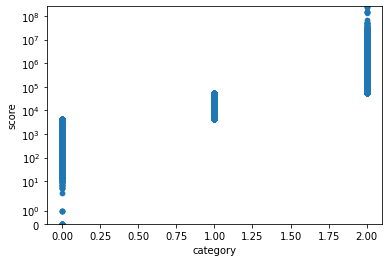

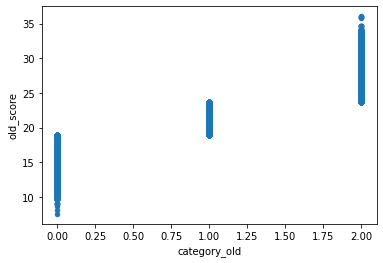

In [ ]:
def gen_scores(raw):
  return pd.DataFrame({'thumbnail': raw['thumbnail'],
                       'score': raw['view'], 
                       'old_score': np.log(raw['view'] * raw['channel_sub'])})

data_p1 = gen_scores(raw_data_p1)
data_p2 = gen_scores(raw_data_p2)
data_p3 = gen_scores(raw_data_p3)
data_p4 = gen_scores(raw_data_p4)
data_all = pd.concat([data_p1, data_p2, data_p3, data_p4], ignore_index=True)

# separate data into 3 equally sized categories
data_all['category_old'] = pd.qcut(data_all.old_score, 3, labels=False)
data_all['category'] = pd.qcut(data_all.score, 3, labels=False)

data_all.plot.scatter(y='score', x='category', ylim=(0, 260000000), logy='sym')
data_all.plot.scatter(y='old_score', x='category_old')
data_all.sort_values(by='score')

In [ ]:
old_data_dir = '/image_data_old/'
os.mkdir(data_dir)
for (cat, data) in data_all.groupby('category'):
    dir = data_dir + str(cat) + '/'
    if not os.path.isdir(dir):
        os.mkdir(dir)
    for row in data.itertuples():
        old_dir = old_data_dir + str(row.category_old) + '/'
        vid_id = row.thumbnail.split('/')[-2]

        old_fname = old_dir +  vid_id + '.jpg'
        fname     = dir +      vid_id + '.jpg'
        if not os.path.isfile(fname):
            if os.path.isfile(old_fname):
                os.rename(old_fname, fname)
                print('.', end='')
            else:
                print('file not found:', old_fname)

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................file not found: /image_data_old/0/fHNmh2Ppi-k.jpg
file not found: /image_data_old/0/mTfBsuqFICU.jpg
file not found: /image_data_old/0/E01xxZ7rvjY.jpg
file not found: /image_data_old/0/BD5ReXQB4Bw.jpg
file not found: /image_data_old/0/g0cavdVFahU.jpg
file not found: /image_data_old/0/pMqI39gT6GM.jpg
...................................................................................................................................................................................................................................................

In [ ]:
!7z a {gdir}/image_data.zip /image_data/
!7z l {gdir}/image_data.zip

Streaming output truncated to the last 5000 lines.
2021-02-22 00:50:53 .....       138099       136896  image_data/2/89R3z662iTk.jpg
2021-02-22 00:48:36 .....       221066       220565  image_data/2/8AIzi3LIOFc.jpg
2021-02-22 00:51:33 .....        78442        75542  image_data/2/8ALKIwwvDsY.jpg
2021-02-22 00:50:26 .....        27996        27067  image_data/2/8Au47gnXs0w.jpg
2021-02-22 00:50:45 .....       144874       144874  image_data/2/8BRQiQCxiGw.jpg
2021-02-22 00:49:46 .....       103386       100289  image_data/2/8BjA4Upx6tc.jpg
2021-02-22 00:51:13 .....       114822       113353  image_data/2/8BjXmfhrkII.jpg
2021-02-22 00:51:16 .....       117602       117419  image_data/2/8BtvT9OscSQ.jpg
2021-02-22 00:49:00 .....       229906       229906  image_data/2/8CNbt95PMV0.jpg
2021-02-22 00:48:28 .....        16724        15643  image_data/2/8FVHXl5AN_0.jpg
2021-02-22 00:48:53 .....        44684        43843  image_data/2/8HM71vWF2jc.jpg
2021-02-22 00:49:56 .....        75129        7

In [ ]:
import socket
socket.setdefaulttimeout(2.5)

for (cat, data) in data_all.groupby('category'):
  dir = data_dir + str(cat) + '/'
  if not os.path.isdir(dir):
    os.mkdir(dir)
  for thumb in data.thumbnail:
    fname = dir + thumb.split('/')[-2] + '.jpg'
    if not os.path.isfile(fname):
      try:
        urllib.request.urlretrieve(thumb, fname)
      except Exception as e:
        print('err: ', fname, e)


not found: /image_data_old/1/fHNmh2Ppi-k.jpg
not found: /image_data_old/1/mTfBsuqFICU.jpg
not found: /image_data_old/1/E01xxZ7rvjY.jpg
not found: /image_data_old/1/BD5ReXQB4Bw.jpg
not found: /image_data_old/1/g0cavdVFahU.jpg
not found: /image_data_old/1/pMqI39gT6GM.jpg
not found: /image_data_old/1/VW5ivgnXrYQ.jpg
not found: /image_data_old/0/zGm5azfWJXM.jpg
not found: /image_data_old/0/2fkZezszcC4.jpg
not found: /image_data_old/1/fHNmh2Ppi-k.jpg
not found: /image_data_old/1/mTfBsuqFICU.jpg
not found: /image_data_old/1/E01xxZ7rvjY.jpg
not found: /image_data_old/1/BD5ReXQB4Bw.jpg
not found: /image_data_old/1/g0cavdVFahU.jpg
not found: /image_data_old/1/pMqI39gT6GM.jpg
not found: /image_data_old/1/y6_LIW43CmU.jpg
not found: /image_data_old/0/BWaDhm5V0Is.jpg
not found: /image_data_old/1/Zg5tLs7gVvE.jpg
not found: /image_data_old/0/l8b-wOV8Lks.jpg
not found: /image_data_old/0/ET8FLZXPzT8.jpg
not found: /image_data_old/0/13h1gX-29qY.jpg
not found: /image_data_old/0/rEZNWBEmv3w.jpg
not found:

In [ ]:
num_skipped = 0
for folder_path in (data_dir + '/' + str(cat) for cat in range(0, 3)):
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            print(fpath, ', ', end='')
            # Delete corrupted image
            os.remove(fpath)

print()
num_skipped

0

# Copy Data From GDrive

In [ ]:
drive.mount('/gdrive', force_remount=True)
!ls /gdrive/MyDrive/Thumbnail-Evaluator/

!7z l {gdir}/image_data.zip | wc -l
!7z x {gdir}/image_data.zip -o/
!ls /image_data/

Mounted at /gdrive
image_data_3cat_log_view_sub.zip  image_data.zip
18517

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /gdrive/MyDrive/Thumbnail-Evaluator/                                              1 file, 1825126039 bytes (1741 MiB)

Extracting archive: /gdrive/MyDrive/Thumbnail-Evaluator/image_data.zip
 22% 4096 Open              --
Path = /gdrive/MyDrive/Thumbnail-Evaluator/image_data.zip
Type = zip
Physical Size = 1825126039

  0%      1% 207 - image_data/0/16S0mWA9ulg.jpg                                         2% 400          2% 542 - image_data/0/4M9I9d84ubs.jpg

## Separate Test set

In [ ]:
os.mkdir(test_data_dir)
for entry in os.scandir(data_dir):
    if entry.is_dir():
        if not os.path.isdir(test_data_dir + '/' + entry.name):
            os.mkdir(test_data_dir + '/' + entry.name)
        for image in os.scandir(entry.path):
            if image.is_file() and image.path.endswith('jpg'):
                if np.random.random_sample() > 0.8:
                    os.rename(image.path, test_data_dir + '/' + entry.name + '/' + image.name)
                    print('.', end='')

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
!ls {data_dir}/* | wc -l
!ls {test_data_dir}/* | wc -l

14824
3681


# Configure Distributed Processing

In [ ]:
# TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_WORKER)
# 
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# 
# strategy = tf.distribute.TPUStrategy(resolver)
# 
# tf.config.set_soft_device_placement(True)

# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    # strategy = tf.distribute.get_strategy

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO
REPLICAS:  1


# Load Labelled Image Data

In [ ]:
# Original size: (360, 480)
image_size = (128, 128)
common = {
  'label_mode': 'categorical',
  # 'class_mode': 'categorical',
  'image_size': image_size,
  # 'target_size': image_size,
  'batch_size': 32,
  'validation_split': 0.23,
  'seed': 12345,
}

image_generator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# training_set = image_generator.flow_from_directory(
training_set = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    subset='training',
    **common
)

# validation_set = image_generator.flow_from_directory(
validation_set = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    subset='validation',
    **common
)

test_set = keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    image_size=image_size,
    label_mode='categorical'
)

training_set = training_set.prefetch(buffer_size=32).cache()
validation_set = validation_set.prefetch(buffer_size=32).cache()
test_set = test_set.prefetch(buffer_size=32).cache()

Found 14798 files belonging to 3 classes.
Using 11395 files for training.
Found 14798 files belonging to 3 classes.
Using 3403 files for validation.
Found 3697 files belonging to 3 classes.


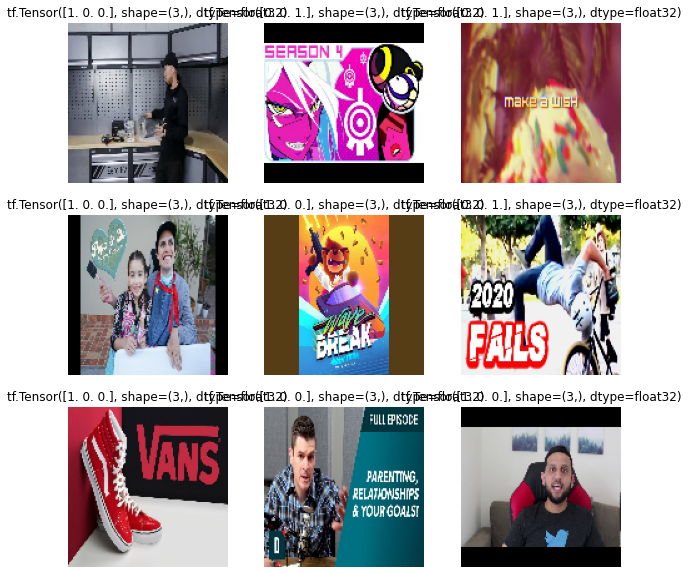

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i]))
        plt.axis("off")


# Build Model


In [ ]:
# Mini Xception net
def build_model(input_shape, num_classes):
    from keras import layers
    inputs = keras.Input(shape=input_shape)

    # Data Augmentation:
    x = keras.Sequential([
        layers.experimental.preprocessing.RandomFlip('horizontal'),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ])(inputs)

    weight_decay = 4e-3 # 1e-2
    
    regularize = {
        'kernel_regularizer': keras.regularizers.l2(l2=weight_decay),
    }

    sep_regularize = {
        'depthwise_regularizer': keras.regularizers.l2(l2=weight_decay),
        'pointwise_regularizer': keras.regularizers.l2(l2=weight_decay),
    }
    
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same", use_bias=False, **regularize)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, padding="same", use_bias=False, **regularize)(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Activation("relu")(x)
    
    previous_block_activation = x  # Set aside residual
    
    for size in [128, 256]: # , 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False, **sep_regularize)(x)
        x = layers.BatchNormalization()(x)
    
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False, **sep_regularize)(x)
        x = layers.BatchNormalization()(x)
    
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False, **regularize)(
            previous_block_activation
        )
        residual = layers.BatchNormalization()(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
    
    x = layers.SeparableConv2D(1024, 3, padding="same", use_bias=False, **sep_regularize)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# Bottlenecking CNN
def _build_model(input_shape, num_classes):
    from keras import layers
    model = keras.models.Sequential()

    activate = {'activation': 'relu'}
    
    model.add(layers.Conv2D(32, (3, 3), input_shape=input_shape, **activate))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    
    for filter in [32, 64, 80, 192]:
        model.add(layers.Conv2D(filter, (3, 3), **activate))
        model.add(layers.BatchNormalization())
        # model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(16, (1, 1), **activate))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(288, (5, 5), **activate))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(16, (1, 1), **activate))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(768, (7, 7), **activate))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(16, (1, 1), **activate))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(1280, (3, 3), **activate))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(128))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(64))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Youssef CNN
def _build_model(input_shape, num_classes):
    from keras import layers
    from keras import regularizers
    from keras.layers import Activation, BatchNormalization, Conv2D, Dense, MaxPooling2D, Flatten
    from keras.layers import Dropout

    weight_decay = 1e-4
    model = keras.models.Sequential()

    model.add(Conv2D(32, (3,3), padding='same',
                     kernel_regularizer=regularizers.l2(weight_decay), 
                     input_shape=input_shape))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    return model

build_model(input_shape=image_size + (3,), num_classes=3).summary()
#keras.utils.plot_model(build_model(), show_shapes=True)
# keras.utils.plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   864         rescaling[0][0]                  
______________________________________________________________________________________________

# Run Model

In [ ]:
!cat /proc/cpuinfo | grep processor | wc -l

2


In [ ]:
epochs = 150

def lr_schedule(epoch):
    lrate = 0.00018
    if epoch > 30:
        lrate = 0.00014
    if epoch > 100:
        lrate = 0.0001
    return lrate

callbacks = [
    keras.callbacks.LearningRateScheduler(lr_schedule),
     # keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

with strategy.scope():
    model = build_model(input_shape=image_size + (3,), num_classes=3)

    model.summary()
    
    model.compile(
        optimizer=tf.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=["accuracy"],
    )

history = model.fit(
    training_set,
    batch_size=64,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_set,
    workers=2,
)

model.save(gdir + '/model.h5')
model.save_weights(gdir + '/model_weights.h5')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 128, 128, 3)  0           sequential_2[0][0]               
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 32)   864         rescaling_2[0][0]                
____________________________________________________________________________________________

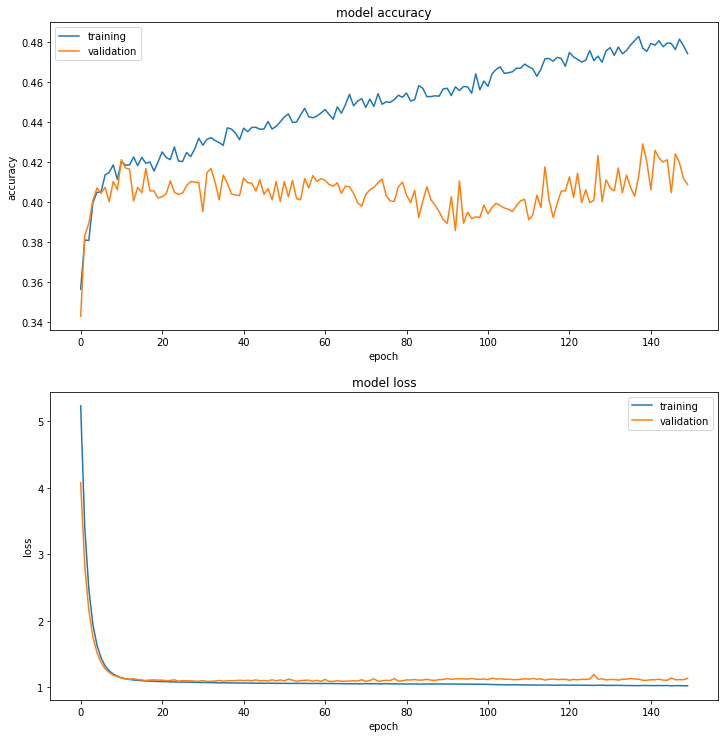

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [ ]:
results = model.evaluate(test_set)
print("test loss, test acc:", results)

# sanity check to see if model was properly saved
loaded_model = keras.models.load_model(gdir + '/model.h5')
results = loaded_model.evaluate(test_set)
print("test loss, test acc:", results)

116/116 [==============================] - 2s 19ms/step - loss: 1.1073 - accuracy: 0.4306
test loss, test acc: [1.107283115386963, 0.43061941862106323]
116/116 [==============================] - 2s 18ms/step - loss: 1.1073 - accuracy: 0.4306
test loss, test acc: [1.107283115386963, 0.43061941862106323]
